In [3]:
import os, sys
# os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
# os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import tensorflow as tf
tf.compat.v1.enable_eager_execution()

import numpy as np
import imageio
import pprint

import matplotlib.pyplot as plt

import run_nerf
import run_nerf_helpers


### Load trained network weights
Run `bash download_example_weights.sh` in the root directory if you need to download the Lego example weights

Args:
expname = model_0_test
basedir = ./logs
datadir = ./data/nerf_lightstage/model_0
dataset_type = lightstage

half_res = True
no_batching = True

N_samples = 64
N_importance = 64

use_viewdirs = True

white_bkgd = True

N_rand = 1024

lrate = 2e-4
MODEL 63 27 <class 'int'> <class 'int'> 48 <class 'int'> True
(?, 138) (?, 63) (?, 27) (?, 48)
MODEL 63 27 <class 'int'> <class 'int'> 48 <class 'int'> True
(?, 138) (?, 63) (?, 27) (?, 48)
Not ndc!
Found ckpts ['./logs/model_0_test/model_100000.npy']
Reloading from ./logs/model_0_test/model_100000.npy
Resetting step to 100001
Reloading fine from ./logs/model_0_test/model_fine_100000.npy
Render kwargs:
{'N_importance': 64,
 'N_samples': 64,
 'far': <tf.Tensor: id=21611, shape=(), dtype=float32, numpy=400.0>,
 'lindisp': False,
 'ndc': False,
 'near': <tf.Tensor: id=21610, shape=(), dtype=float32, numpy=100.0>,
 'network_fine': <tensorflow.python.keras.engine.training.Model object at 0x7f4ee86b0650>,
 'network_fn': <tensorflow.python.keras

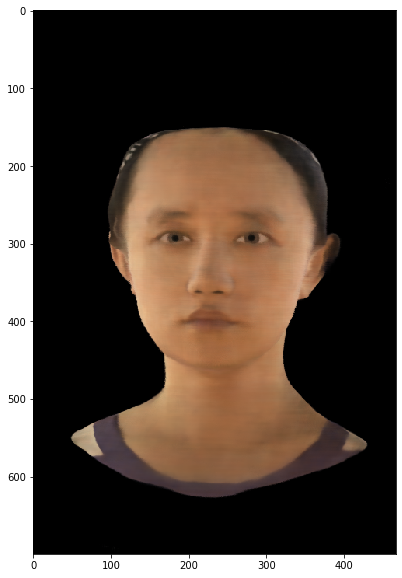

In [4]:
basedir = './logs'
expname = 'model_0_test'

config = os.path.join(basedir, expname, 'config.txt')
print('Args:')
print(open(config, 'r').read())

parser = run_nerf.config_parser()
ft_str = '' 
ft_str = '--ft_path {}'.format(os.path.join(basedir, expname, 'model_100000.npy'))
args = parser.parse_args('--config {} '.format(config) + ft_str)

# Create nerf model
_, render_kwargs_test, start, grad_vars, models = run_nerf.create_nerf(args)

# bds_dict = {
#     'near' : tf.cast(2., tf.float32),
#     'far' : tf.cast(6., tf.float32),
# }
bds_dict = {
    'near' : tf.cast(100., tf.float32),
    'far' : tf.cast(400., tf.float32),
}
render_kwargs_test.update(bds_dict)

print('Render kwargs:')
pprint.pprint(render_kwargs_test)

net_fn = render_kwargs_test['network_query_fn']
print(net_fn)

# Render an overhead view to check model was loaded correctly
# c2w = np.eye(4)[:3,:4].astype(np.float32) # identity pose matrix
# c2w[2,0] = 40
# c2w[2,1] = -10
# c2w[2,-1] = 200.
# H, W, focal = 800, 800, 1200.
# down = 8
hwf_default = [
    1400,
    935,
    5000
]
H, W, focal = hwf_default
down = 2

# pose_default = np.array([
#     [0.969688, -0.015023, -0.243882, -31.838964],
#     [0.020412, 0.9996, 0.019582, 3.707516],
#     [0.24349, -0.023967, 0.969607, 126.527136],
#     [0.0, 0.0, 0.0, 1.0]
# ]) # [test] Envrion_38_model_0_camview_00359_cameraDis_10_00002_0
pose_default = np.array([
    [0.954049,-0.017926,0.299115,47.847337],
    [0.017324,0.999839,0.004666,1.898512],
    [-0.299151,0.00073,0.954206,152.670795],
    [0.0,0.0,0.0,1.0]
]) # [train] Envrion_38_model_0_camview_00359_cameraDis_10_00002_0
c2w=pose_default[:3,:4]

sh_default = np.array([
    [0.638712, 0.284742, 0.118981],
    [-0.121597, -0.0644393, -0.0280195],
    [-0.0704244, -0.0440014, -0.0278942],
    [-0.00941534, -0.0196714, -0.0270952],
    [0.0244973, 0.019399, 0.0146708],
    [-0.0738909, -0.0249716, -0.00191948],
    [-0.112882, -0.0680578, -0.0321083],
    [-0.0018545, -0.00141121, -0.00426523],
    [0.121973, 0.109539, 0.0996329],
    [0.195734, 0.0611543, -0.0115104],
    [-0.0243289, -0.0109742, -0.00370652],
    [0.119068, 0.0567287, 0.0189506],
    [-0.0188627, -0.00730853, -0.0120698],
    [-0.0146965, -0.00352992, 0.00319044],
    [-0.00446196, -0.00805026, -0.00354193],
    [-0.000833787, -0.0136447, -0.0227599]
]).astype(np.float32)  # [train] 03-Ueno-Shrine_3k.exr environ_1

# sh_default = np.array([
#     [0.384551, 0.550911, 0.648031],
#     [0.0507057, 0.143594, 0.162893],
#     [0.0772031, 0.0780929, 0.0637051],
#     [-0.0599465, -0.0553679, -0.0607599],
#     [-0.053981, -0.0625365, -0.0588478],
#     [-0.054841, -0.0534936, -0.0385908],
#     [-0.0886663, -0.159897, -0.186837],
#     [-0.0422187, -0.0393604, -0.0216017],
#     [0.0703713, -0.0125982, -0.0435647],
#     [-0.107585, -0.193392, -0.196227],
#     [0.0383513, 0.0572401, 0.0579979],
#     [-0.0616553, -0.122991, -0.136459],
#     [0.00924805, 0.00253273, -0.00701328],
#     [-0.0991606, -0.129509, -0.124769],
#     [0.0439391, 0.029741, 0.00132114],
#     [0.0704215, 0.0766156, 0.0935258]
# ]).astype(np.float32)  # [train] environ_2

# sh_default = np.array([
#     [0.495062, 0.488898, 0.435773],
#     [0.119356, 0.115539, 0.0845214],
#     [-0.092344, -0.0897128, -0.0750387],
#     [-0.110423, -0.108983, -0.106673],
#     [0.00278939, 0.00531122, -0.00418585],
#     [0.13986, 0.156401, 0.169873],
#     [-0.0196414, -0.0211737, -0.0114855],
#     [-0.000150129, 0.00337954, 0.00480531],
#     [-0.121594, -0.11627, -0.0817691],
#     [-0.237269, -0.230567, -0.198399],
#     [-0.0196532, -0.020019, -0.0137517],
#     [-0.184584, -0.191687, -0.167073],
#     [-0.0329199, -0.0356011, -0.0404005],
#     [0.0290783, 0.0244402, 0.0291908],
#     [-0.0829435, -0.0885313, -0.104823],
#     [0.0276235, 0.0249594, 0.0366425]
# ]).astype(np.float32)  # [train] environ_12

# sh_default = np.array([
#     [0.66776, 0.894503, 1.14148],
#     [0.069359, 0.0974189, 0.137702],
#     [0.100861, 0.117954, 0.116272],
#     [-0.00237647, -0.00192872, -0.00393376],
#     [0.00161087, 0.00218087, 0.00445831],
#     [-0.0796456, -0.0889044, -0.0730431],
#     [0.0879442, 0.0954396, 0.0831041],
#     [0.0126645, 0.0167633, 0.0171347],
#     [0.0308453, 0.0442546, 0.0629077],
#     [-0.045272, -0.0641559, -0.0821277],
#     [-0.0239643, -0.0344364, -0.0381861],
#     [-0.0884761, -0.0999005, -0.0835839],
#     [0.0619579, 0.0707961, 0.0782535],
#     [-0.0222477, -0.030553, -0.0458214],
#     [0.0491146, 0.0705144, 0.0964576],
#     [0.000105442, 0.000859119, 0.00301107]
# ]).astype(np.float32)  # [test] glacier.exr environ_38

test = run_nerf.render(H//down, W//down, focal/down, c2w=c2w, sh=sh_default, **render_kwargs_test)
img = np.clip(test[0],0,1)
plt.figure(figsize=(10,10))
plt.imshow(img)
plt.show()

In [3]:
basedir_lego = './logs'
expname_lego = 'lego_test'

config_lego = os.path.join(basedir_lego, expname_lego, 'config.txt')
print('Args:')
print(open(config_lego, 'r').read())

parser_lego = run_nerf.config_parser()
ft_str_lego = '' 
ft_str_lego = '--ft_path {}'.format(os.path.join(basedir_lego, expname_lego, 'model_100000.npy'))
args_lego = parser_lego.parse_args('--config {} '.format(config_lego) + ft_str_lego)

# Create nerf model
_, render_kwargs_test_lego, start_lego, grad_vars_lego, models_lego = run_nerf.create_nerf(args_lego)

bds_dict_lego = {
    'near' : tf.cast(2., tf.float32),
    'far' : tf.cast(6., tf.float32),
}
render_kwargs_test_lego.update(bds_dict_lego)

print('Render kwargs:')
pprint.pprint(render_kwargs_test_lego)

net_fn_lego = render_kwargs_test_lego['network_query_fn']
print(net_fn_lego)

# Render an overhead view to check model was loaded correctly
test_lego = run_nerf.render(H//down, W//down, focal/down, c2w=c2w, **render_kwargs_test_lego)
img_lego = np.clip(test_lego[0],0,1)
plt.imshow(img_lego)
plt.show()



Args:
expname = lego_test
basedir = ./logs
datadir = ./data/nerf_synthetic/lego
dataset_type = blender

half_res = True
no_batching = True

N_samples = 64
N_importance = 64

use_viewdirs = True

white_bkgd = True

N_rand = 1024
MODEL 63 27 <class 'int'> <class 'int'> 48 <class 'int'> True
(?, 138) (?, 63) (?, 27) (?, 48)
MODEL 63 27 <class 'int'> <class 'int'> 48 <class 'int'> True
(?, 138) (?, 63) (?, 27) (?, 48)
Not ndc!
Found ckpts ['./logs/lego_test/model_100000.npy']
Reloading from ./logs/lego_test/model_100000.npy


ValueError: Layer weight shape (111, 256) not compatible with provided weight shape (63, 256)

Args:
expname = hotdog_test
basedir = ./logs
datadir = ./data/nerf_synthetic/hotdog
dataset_type = blender

half_res = True
no_batching = True

N_samples = 64
N_importance = 64

use_viewdirs = True

white_bkgd = True

N_rand = 1024

lrate = 1e-3
MODEL 63 27 <class 'int'> <class 'int'> True
(?, 90) (?, 63) (?, 27)
MODEL 63 27 <class 'int'> <class 'int'> True
(?, 90) (?, 63) (?, 27)
Not ndc!
Found ckpts ['./logs/hotdog_test/model_100000.npy']
Reloading from ./logs/hotdog_test/model_100000.npy
Resetting step to 100001
Reloading fine from ./logs/hotdog_test/model_fine_100000.npy
Render kwargs:
{'N_importance': 64,
 'N_samples': 64,
 'far': <tf.Tensor: id=8951, shape=(), dtype=float32, numpy=6.0>,
 'lindisp': False,
 'ndc': False,
 'near': <tf.Tensor: id=8950, shape=(), dtype=float32, numpy=2.0>,
 'network_fine': <tensorflow.python.keras.engine.training.Model object at 0x7f4169b20610>,
 'network_fn': <tensorflow.python.keras.engine.training.Model object at 0x7f4169ba3290>,
 'network_query_f

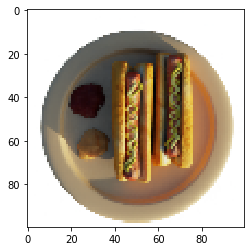

In [4]:
basedir_hotdog = './logs'
expname_hotdog = 'hotdog_test'

config_hotdog = os.path.join(basedir_hotdog, expname_hotdog, 'config.txt')
print('Args:')
print(open(config_hotdog, 'r').read())

parser_hotdog = run_nerf.config_parser()
ft_str_hotdog = '' 
ft_str_hotdog = '--ft_path {}'.format(os.path.join(basedir_hotdog, expname_hotdog, 'model_100000.npy'))
args_hotdog = parser_hotdog.parse_args('--config {} '.format(config_hotdog) + ft_str_hotdog)

# Create nerf model
_, render_kwargs_test_hotdog, start_hotdog, grad_vars_hotdog, models_hotdog = run_nerf.create_nerf(args_hotdog)

bds_dict_hotdog = {
    'near' : tf.cast(2., tf.float32),
    'far' : tf.cast(6., tf.float32),
}
render_kwargs_test_hotdog.update(bds_dict_hotdog)

print('Render kwargs:')
pprint.pprint(render_kwargs_test_hotdog)

net_fn_hotdog = render_kwargs_test_hotdog['network_query_fn']
print(net_fn_hotdog)

# Render an overhead view to check model was loaded correctly
test_hotdog = run_nerf.render(H//down, W//down, focal/down, c2w=c2w, **render_kwargs_test_hotdog)
img_hotdog = np.clip(test_hotdog[0],0,1)
plt.imshow(img_hotdog)
plt.show()


{'network_query_fn': <function create_nerf.<locals>.network_query_fn at 0x7f42882115f0>, 'perturb': False, 'N_importance': 64, 'network_fine': <tensorflow.python.keras.engine.training.Model object at 0x7f42080c0f50>, 'N_samples': 64, 'network_fn': <tensorflow.python.keras.engine.training.Model object at 0x7f42881c29d0>, 'use_viewdirs': True, 'white_bkgd': True, 'raw_noise_std': 0.0, 'ndc': False, 'lindisp': False, 'near': <tf.Tensor: id=988, shape=(), dtype=float32, numpy=2.0>, 'far': <tf.Tensor: id=989, shape=(), dtype=float32, numpy=6.0>, 'network_query_fn_': <function create_nerf.<locals>.network_query_fn at 0x7f4180045d40>, 'perturb_': False, 'N_importance_': 64, 'network_fine_': <tensorflow.python.keras.engine.training.Model object at 0x7f4169d08750>, 'N_samples_': 64, 'network_fn_': <tensorflow.python.keras.engine.training.Model object at 0x7f42882edbd0>, 'white_bkgd_': True, 'raw_noise_std_': 0.0, 'lindisp_': False}
{'network_query_fn': <function create_nerf.<locals>.network_que

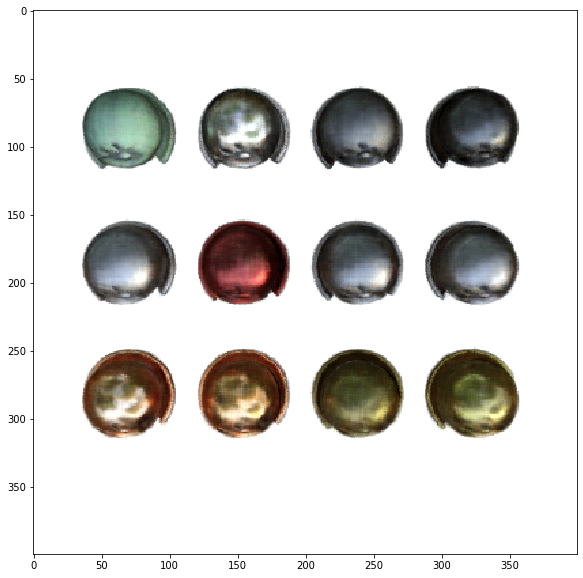

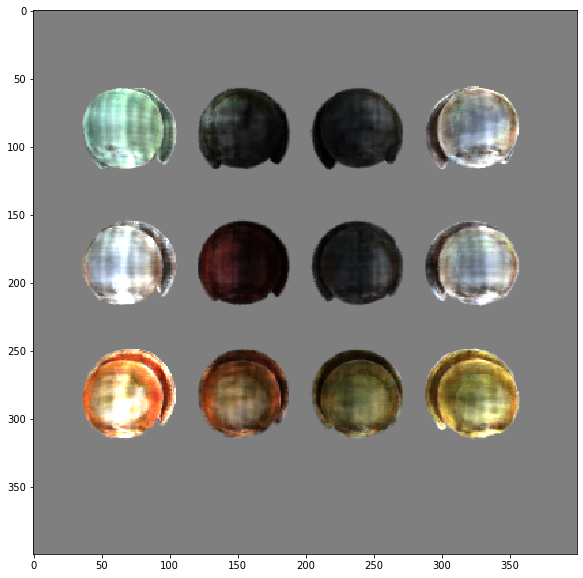

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


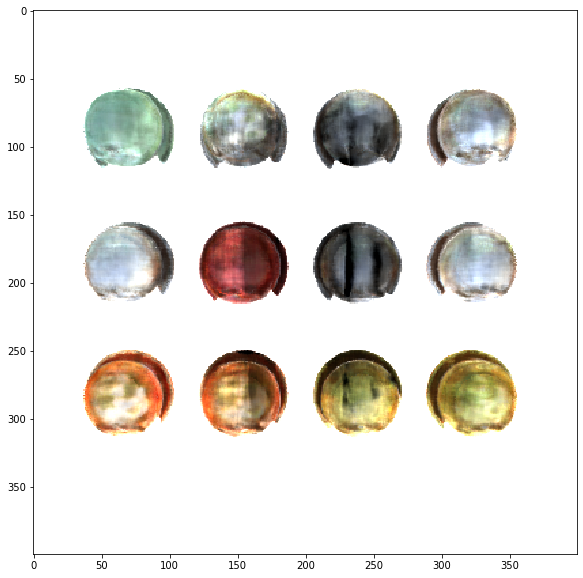

In [13]:
# temp = {}
temp_lego = render_kwargs_test.copy()
for key in render_kwargs_test_lego:
    filter = {
        'use_viewdirs': True,
        'ndc': True,
        'near': True,
        'far': True
    }
    if filter.get(key): continue
    temp_lego[key+'_'] = render_kwargs_test_lego[key]
print(temp_lego)

temp_hotdog = render_kwargs_test.copy()
for key in render_kwargs_test_hotdog:
    filter = {
        'use_viewdirs': True,
        'ndc': True,
        'near': True,
        'far': True
    }
    if filter.get(key): continue
    temp_hotdog[key+'_'] = render_kwargs_test_hotdog[key]
print(temp_hotdog)

down_ = 2

result = run_nerf.render(H//down_, W//down_, focal/down_, c2w=c2w, **render_kwargs_test)
result_lego = run_nerf.render(H//down_, W//down_, focal/down_, c2w=c2w, **temp_lego)
result_hotdog = run_nerf.render(H//down_, W//down_, focal/down_, c2w=c2w, **temp_hotdog)

# result_lego = np.multiply(result_leg[0])

result = np.clip(result[0],0,1)
result_lego = np.clip(result_lego[0] / 2,0,1)
result_hotdog = np.clip(result_hotdog[0],0,1) * 4


plt.figure(figsize=(10,10))
plt.imshow(result)
plt.show()
plt.figure(figsize=(10,10))
plt.imshow(result_lego)
plt.show()
plt.figure(figsize=(10,10))
plt.imshow(result_hotdog)
plt.show()

In [1]:
### Query network on dense 3d grid of points

In [2]:
N = 256
t = np.linspace(-1.2, 1.2, N+1)

query_pts = np.stack(np.meshgrid(t, t, t), -1).astype(np.float32)
print(query_pts.shape)
sh = query_pts.shape
flat = query_pts.reshape([-1,3])


def batchify(fn, chunk):
    if chunk is None:
        return fn
    def ret(inputs):
        return tf.concat([fn(inputs[i:i+chunk]) for i in range(0, inputs.shape[0], chunk)], 0)
    return ret
    
    
fn = lambda i0, i1 : net_fn(flat[i0:i1,None,:], viewdirs=np.zeros_like(flat[i0:i1]), network_fn=render_kwargs_test['network_fine'])
chunk = 1024*64
raw = np.concatenate([fn(i, i+chunk).numpy() for i in range(0, flat.shape[0], chunk)], 0)
raw = np.reshape(raw, list(sh[:-1]) + [-1])
sigma = np.maximum(raw[...,-1], 0.)

print(raw.shape)
plt.hist(np.maximum(0,sigma.ravel()), log=True)
plt.show()

NameError: name 'np' is not defined

### Marching cubes with [PyMCubes](https://github.com/pmneila/PyMCubes)
Change `threshold` to use a different sigma threshold for the isosurface

In [ ]:
import mcubes

threshold = 50.
print('fraction occupied', np.mean(sigma > threshold))
vertices, triangles = mcubes.marching_cubes(sigma, threshold)
print('done', vertices.shape, triangles.shape)

### Uncomment to save out the mesh
# mcubes.export_mesh(vertices, triangles, "logs/lego_example/lego_{}.dae".format(N), "lego")

### Live preview with [trimesh](https://github.com/mikedh/trimesh)
Click and drag to change viewpoint

In [ ]:
import trimesh

mesh = trimesh.Trimesh(vertices / N - .5, triangles)
mesh.show()

### Save out video with [pyrender](https://github.com/mmatl/pyrender)

In [ ]:
os.environ["PYOPENGL_PLATFORM"] = "egl"
import pyrender
from load_blender import pose_spherical

In [ ]:
scene = pyrender.Scene()
scene.add(pyrender.Mesh.from_trimesh(mesh, smooth=False))

# Set up the camera -- z-axis away from the scene, x-axis right, y-axis up
camera = pyrender.PerspectiveCamera(yfov=np.pi / 3.0)

camera_pose = pose_spherical(-20., -40., 1.).numpy()
nc = pyrender.Node(camera=camera, matrix=camera_pose)
scene.add_node(nc)

# Set up the light -- a point light in the same spot as the camera
light = pyrender.PointLight(color=np.ones(3), intensity=4.0)
nl = pyrender.Node(light=light, matrix=camera_pose)
scene.add_node(nl)

# Render the scene
r = pyrender.OffscreenRenderer(640, 480)
color, depth = r.render(scene)

plt.imshow(color)
plt.show()
plt.imshow(depth)
plt.show()


In [ ]:
imgs = []
for th in np.linspace(0, 360., 120+1)[:-1]:
    camera_pose = pose_spherical(th, -40., 1.).numpy()
    scene.set_pose(nc, pose=camera_pose)
    imgs.append(r.render(scene)[0])
f = 'logs/lego_example/lego_mesh_turntable.mp4'
imageio.mimwrite(f, imgs, fps=30)
print('done')

In [ ]:
from IPython.display import HTML
from base64 import b64encode
mp4 = open(f,'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls autoplay loop>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)